<a href="https://colab.research.google.com/github/livinNector/deep-learning-tools-lab/blob/main/1%20-%20Data%20Augumentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Data Augumentation Pipeline Using Tensorflow

References:
- [Data Augumentation](https://www.tensorflow.org/tutorials/images/data_augmentation)
- [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

## Setup and Loading data

### Importing Modules

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Loading CIFAR-10 dataset using tensorflow.keras.datasets

The dataset used is the CIFAR-10 image classification dataset.
It consists of 10 image classes.
- [Dataset webpage](https://www.cs.toronto.edu/~kriz/cifar.html)

In [6]:
from tensorflow.keras.datasets import cifar10

In [7]:
train_ds, test_ds = cifar10.load_data() # Load the datset 
train_ds = tf.data.Dataset.from_tensor_slices(train_ds) # Creating a pipeline with training set

### Utility function for displaying sample images

In [4]:
def show_images(images):
    n = len(images)
    for i,image in enumerate(images):
        plt.subplot(1,n,i+1)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

## Method 1 - Data Augumentation using Keras preprocessing Layers (`tf.keras.layers`)

Keras preprocessing layers for data augumentation
  - `tf.keras.layers.Resizing`
  - `tf.keras.layers.Rescaling `
  - `tf.keras.layers.RandomFlip`
  - `tf.keras.layers.RandomRotation`
  - `tf.keras.layers.RandomContrast`
  - `tf.keras.layers.RandomCrop`
  - `tf.keras.layers.RandomZoom`
  
Keras Preprocessing layers can be incorporated into the model thus can utilize GPU while deployment in server side.

- Resizing and Rescaling can be used to standardize the size of the image and the range of pixel values.
- RandomFlip and RandomRotation can be used to create random basic transformations

The Keras Layer can be used to apply Data augumentation in 2 methods:
1. Can be directly added to the model. Thus enabling the model to intake raw unprocessed input.
2. Can be applied to the dataset using `tf.data` API using `map` method.

### `take` and `map`
The discription of the take and map methods are given below. Click them to know more about them.
- [`take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) is used to take `n` elements from the dataset
- [`map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) is used to apply a function to the elements in dataset


### Preprocessing with Rezising and Rescaling Layers

In [18]:
IMG_SIZE =32
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE,IMG_SIZE),
    tf.keras.layers.Rescaling(1/256) # 0-255 to 0-1
])

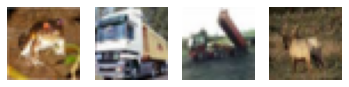

In [19]:
resized_images = train_ds.take(4).map(lambda x,y: resize_and_rescale(x))
show_images(resized_images)

### Other Augumentation Layers

In [20]:
data_augumentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(factor=.2),
    tf.keras.layers.RandomContrast(factor=(.2,.9),),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


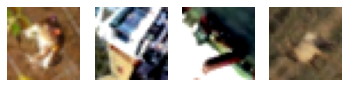

In [21]:
aug_images = resized_images.map(lambda x: data_augumentation(x))
show_images(aug_images)

### Applying keras preprocessing layer to the dataset

The above two steps can be combined into a function `prepare` to apply both `resize_and_rescale` and `data_augumentation` to the dataset.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds):
    ds = ds.map(lambda x,y: (resize_and_rescale(x),y),num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x,y: (data_augumentation(x),y),num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


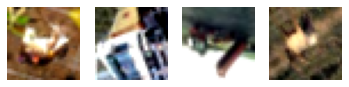

In [13]:
prepared_ds = prepare(train_ds.take(4)) # take 4 elements from dataset and prepare
show_images(prepared_ds.map(lambda x,y:x)) # removing y from dataset to display the images

### Adding Augumenting Keras Layers to the model

As mention earlier, an another way to use the keras layers is to add them directly to the model.

In [ ]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augumentation,
    tf.keras.layers.Conv2D(16,3),
    tf.keras.layers.MaxPooling2D(),
    # The rest of the model goes here
])
model.compile() ## This is not the full model . this shows how this can be used

## Method 2 - Data Augumentation using `tf.image`


- Using the tf.image methods, 
  - `tf.image.flip_left_right`
  - `tf.image.rgb_to_grayscale`
  - `tf.image.adjust_brightness`
  - `tf.image.central_crop`

The above methods apply deterministic(same every time) transformations to the images.

To apply random transformations `tf.image.stateless_random*` can be used. They are:
  - `tf.image.stateless_random_brightness`
  - `tf.image.stateless_random_contrast`
  - `tf.image.stateless_random_crop`
  - `tf.image.stateless_random_flip_left_right`
  - `tf.image.stateless_random_flip_up_down`
  - `tf.image.stateless_random_hue`
  - `tf.image.stateless_random_jpeg_quality`
  - `tf.image.stateless_random_saturation`

These transformations can be applied to the dataset using `tf.data.Dataset` pipeline using map method.

### Applying transformations in a single image

In [14]:
image , label = next(iter(train_ds)) # take a single image from the dataset

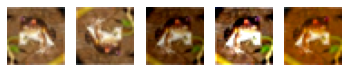

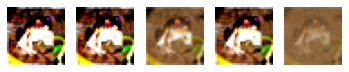

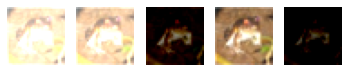

In [15]:
show_images([
    tf.image.flip_left_right(image),
    tf.image.flip_up_down(image),
    tf.image.adjust_brightness(image,-.2),
    tf.image.adjust_contrast(image,2),
    tf.image.adjust_saturation(image,2),
]) # manual augumentation 

show_images([
    tf.image.stateless_random_contrast(image, lower=.1,upper=5,seed = (i,0))
    for i in range(1,6)
]) # random contrast change with different seeds
show_images([
    tf.image.stateless_random_brightness(image, max_delta=.8,seed = (i,0))
    for i in range(1,6)
]) # random brightness change with different seeds

# Note: seed is a Tensor of shape (2,) whose values are any integers

### Applying augumentations to the dataset

In [28]:
def resize_and_rescale(img):
    img = tf.cast(img,tf.float32) # convert to float
    img = tf.image.resize(img,(32,32))
    img = img/255.0 # rescaling 0-255 to 0-1
    return img

def augument(img_label,seed):
    image,label = img_label
    image = resize_and_rescale(image)

    # Random crop back to the original size.
    image = tf.image.stateless_random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
    # Random brightness.
    image = tf.image.stateless_random_brightness( image, max_delta=0.5, seed=seed)
    image = tf.clip_by_value(image, 0, 1)
    return image,label



In [29]:
# Create a random number generator
rng = tf.random.Generator.from_seed(1,alg="philox") 

In [30]:
# create a function to create seeds for the augument function
def augument_wrapper(image,label):
    seed = rng.make_seeds(2)[0] # stateless random ops require two seeds 
    image,label = augument((image,label),seed)
    return image,label

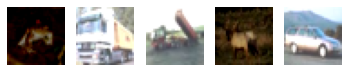

In [31]:
augumented_ds = train_ds.take(5).map(augument_wrapper)
show_images(augumented_ds.map(lambda x,y : x)) # seperate images from the dataset and display